# Dataquest.io Guided Project - Credit Card Customer segmentation
The intent of this project is to take some customer data from a credit card company and apply an unsupervised machine learning approach to segment the customers into groups.
We're going to use the K-means algorithm. At the end, after defining the customer groups, we'll return the data set with each customer into one of them, so the business cases can be made for various types of advertising and promotions

## Data schema
- **customer_id:** unique identifier for each customer.
- **age:** customer age in years.
- **gender:** customer gender (M or F).
- **dependent_count:** number of dependents of each customer.
- **education_level:** level of education ("High School", "Graduate", etc.).
- **marital_status:** marital status ("Single", "Married", etc.).
- **estimated_income:** the estimated income for the customer projected by the data science team.
- **months_on_book:** time as a customer in months.
- **total_relationship_count:** number of times the customer contacted the company.
- **months_inactive_12_mon:** number of months the customer did not use the credit card in the last 12 months.
- **credit_limit:** customer's credit limit.
- **total_trans_amount:** the overall amount of money spent on the card by the customer.
- **total_trans_count:** the overall number of times the customer used the card.
- **avg_utilization_ratio:** daily average utilization ratio.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [2]:
# Read the data
customers = pd.read_csv('customer_segmentation.csv')

In [3]:
# Get basic information about the dataset
print(customers.shape)  # Number of rows and columns
print(customers.columns)  # Column names

(10127, 14)
Index(['customer_id', 'age', 'gender', 'dependent_count', 'education_level',
       'marital_status', 'estimated_income', 'months_on_book',
       'total_relationship_count', 'months_inactive_12_mon', 'credit_limit',
       'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio'],
      dtype='object')


There's 10127 customers, a good sample size

In [4]:
# Check the data types
print(customers.dtypes)

# Check for categorical variables
categorical_cols = customers.select_dtypes(include='object').columns
print(categorical_cols)

customer_id                   int64
age                           int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
dtype: object
Index(['gender', 'education_level', 'marital_status'], dtype='object')


We'll need to turn the categorical columns into numeric scale for the K-Means algorithm to work, but we'll tackle that later.

In [5]:
# Check for missing values
print(customers.isnull().sum())

customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64


No missing data, which is good, saves us having to do some inference or cleaning

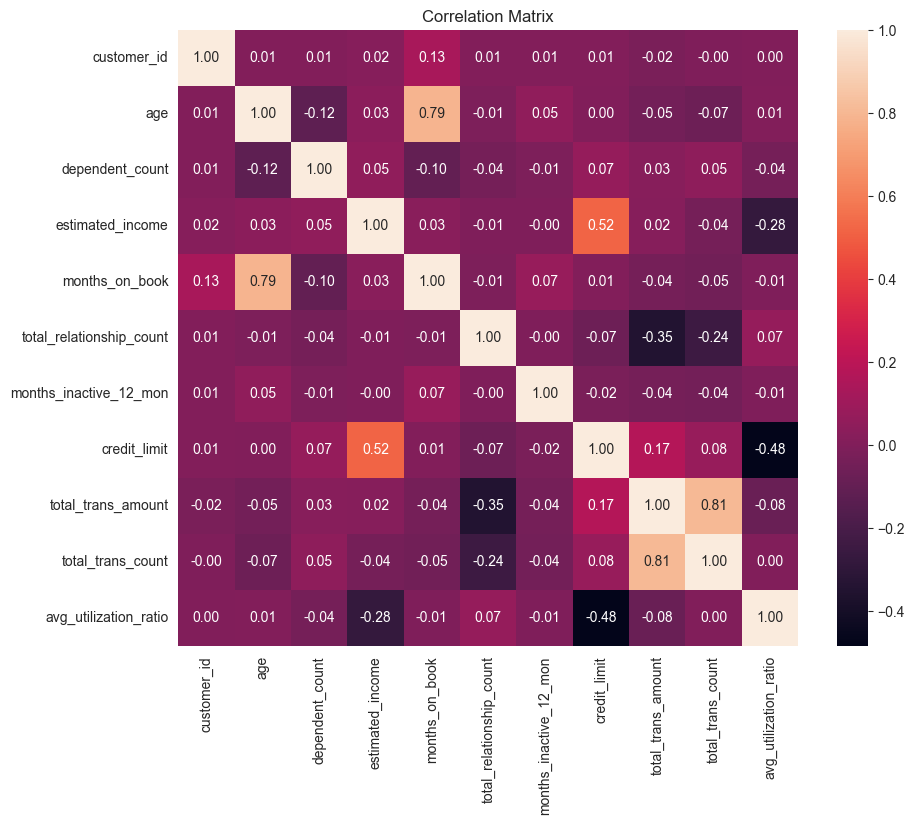

In [6]:
# Calculate correlation for numerical columns only
numerical_cols = customers.select_dtypes(include='number').columns
correlation_matrix = customers[numerical_cols].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

No surprising correlations here, as customers get older, they have more **months_on_book**

**credit_limit** and **estimated_income** being positively correlated makes sense, higher limits tend to be given to those with higher incomes.

**credit_limit** and **avg_utlization_ratio** having a negative correlation is interesting, suggesting that those with higher limits, use it less, and those with lower limits use it more

**credit_limit** and **total_trans_amount** being slightly correlated 0.17

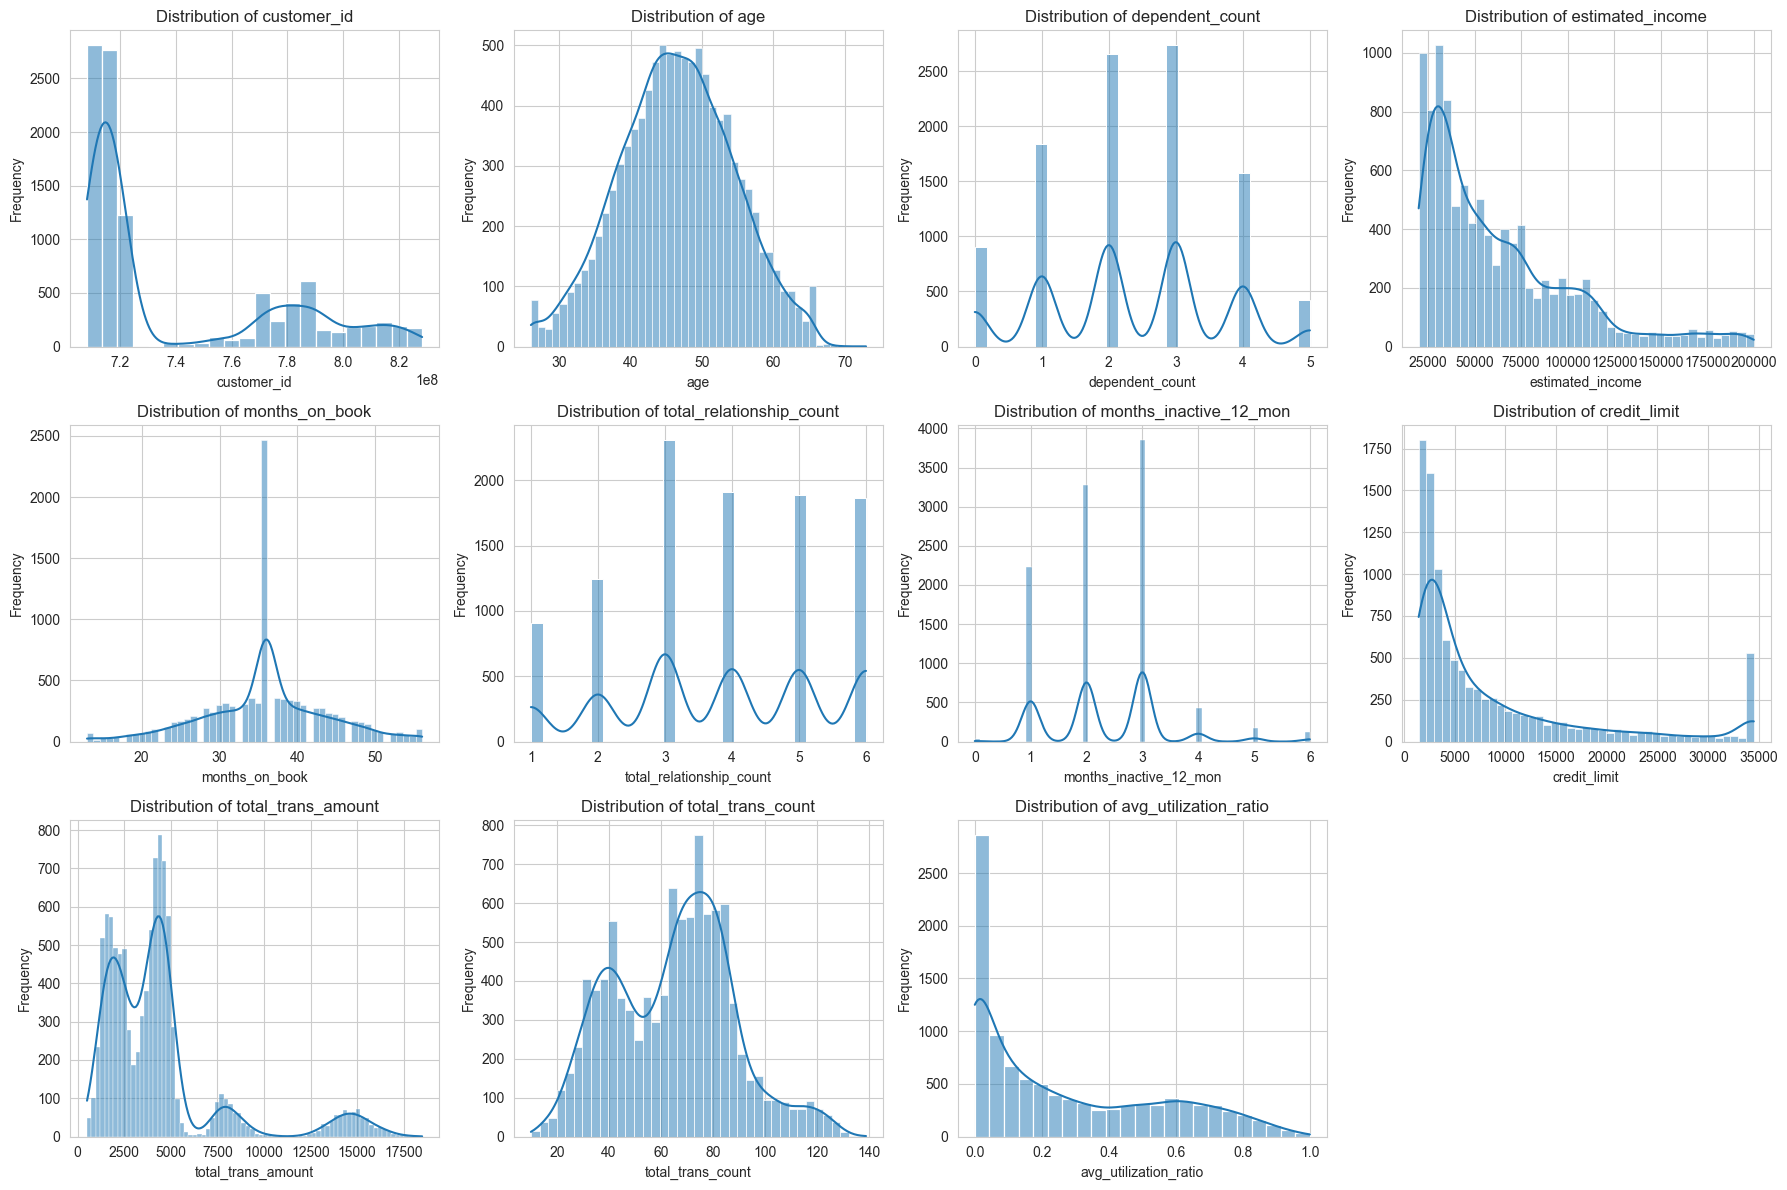

In [7]:
# Plot distributions in 3 columns side by side
plt.figure(figsize=(18, 12))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, (len(numerical_cols) + 2) // 3, i)
    sns.histplot(customers[col], bins="auto", kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

There some interesting results. **age**, **dependent_count**, **estimated_income**, **total_relationship_count** all follow the expected distributions.

The **months_on_book** shows a large spike around 36 months, which suggests 3 years ago there was large and effective promotional camapign to sign up users that was only valid for that particular month

The **credit_limit** shows an expected distribution with a peak at 35000, indicating there's a large number ~500 high wealth clients that are comfortable and eligible for that kind of limit

The **total_trans_amount** shows 4 discrete distributions, centred around 1000, 3000, 8000 and 15000. Suggesting there's 4 classes or categories of purchases

The **total_trans_count** shows 2 main distributions 40, 70 with a 3rd masked at ~120, indicating 3 classes of customer that have low, medium or high usage

The **avg_utilization_ratio**  shows there is a large proportion of customers ~3000, or ~1/3rd of our data set don't use the credit card at all, as though it's there as a safety net. With that distribution tailing off into more regular use. There's a distribution of customers that used it every three out of 5 days on average, and very few customers that use it every day.

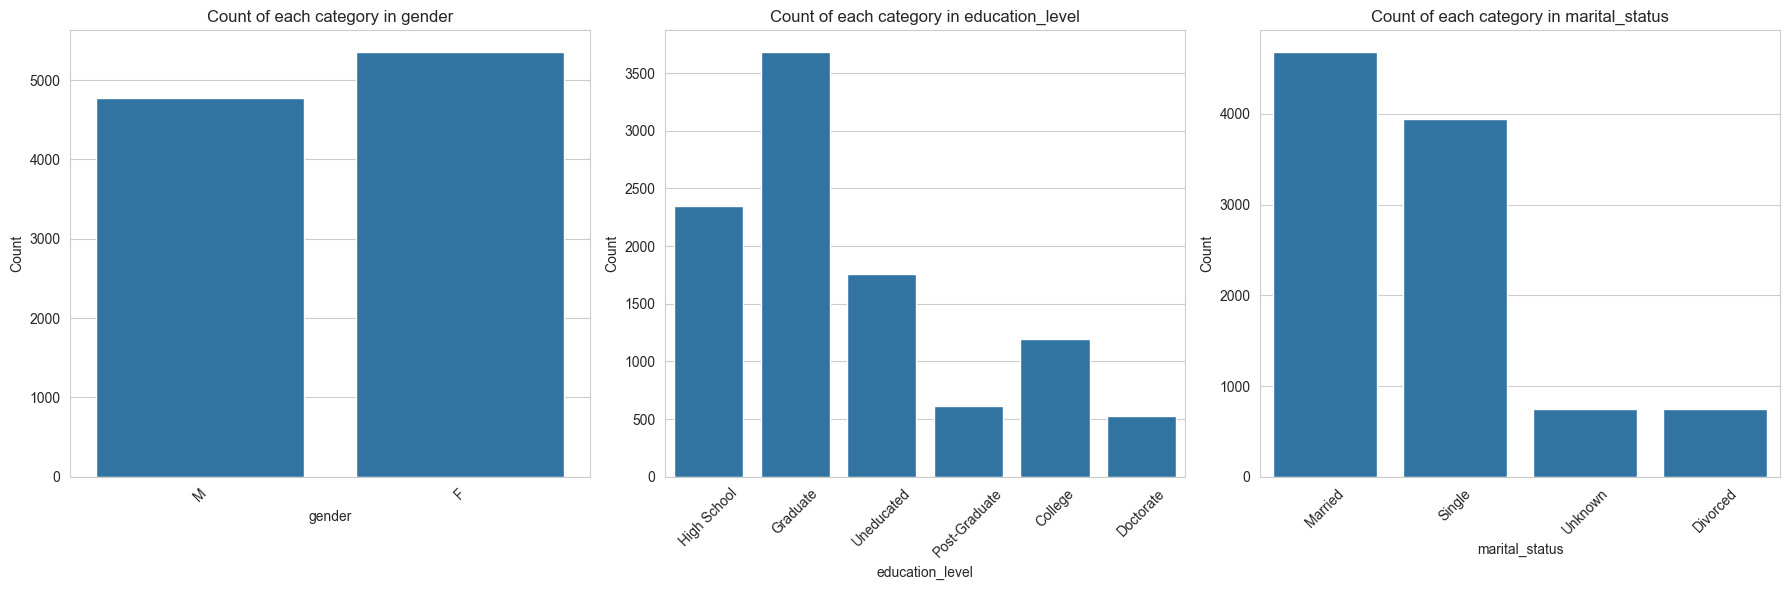

In [8]:
# Plot bar chart for each categorical column in 3 columns side by side
num_categorical_cols = len(categorical_cols)
num_rows = (num_categorical_cols + 2) // 3  # Determine the number of rows needed

plt.figure(figsize=(18, 6 * num_rows))  # Adjust the figure size according to the number of rows

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(num_rows, 3, i)  # Create subplots with 3 columns
    sns.countplot(data=customers, x=col)
    plt.title(f'Count of each category in {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

The gender split slightly favours women, about 52:48

The education level shows about 1/3rd of customers are graduates, and about 1/3rd of customers have high school or lower education level

The marital satus shows nearly half of the customers are married, and 40% are single, with the remaining either divorced or unknown


In [9]:
customers_modif = customers.copy()


In [10]:
# Get distinct values from the 'education_level' column
distinct_education_levels = customers['education_level'].unique()
print(distinct_education_levels)

['High School' 'Graduate' 'Uneducated' 'Post-Graduate' 'College'
 'Doctorate']


In [11]:
customers_modif['gender'] = customers_modif['gender'].map({'M': 1, 'F': 0})
customers_modif['education_level'] = customers_modif['education_level'].map({
    'Uneducated': 0,
    'High School': 1,
    'College': 2,
    'Graduate': 3,
    'Post-Graduate': 4,
    'Doctorate': 5
})

# Convert marital_status into dummy variables
marital_status_dummies = pd.get_dummies(customers_modif['marital_status'], prefix='marital_status')
customers_modif = pd.concat([customers_modif, marital_status_dummies], axis=1)

# Dropping the original 'marital_status' column
customers_modif.drop('marital_status', axis=1, inplace=True)

In [12]:
X = customers_modif.drop('customer_id', axis=1)
X.head(5)


,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,False,True,False,False
1,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,False,False,True,False
2,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,False,True,False,False
3,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,False,False,False,True
4,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,False,True,False,False


In [13]:
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled[:10]
scaled_data = pd.DataFrame(X_scaled)
scaled_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,-0.282405,1.077338,-0.798507,-0.282609
1,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.282405,-0.928214,1.252337,-0.282609
2,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,-0.282405,1.077338,-0.798507,-0.282609
3,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.282405,-0.928214,-0.798507,3.538459
4,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,-0.282405,1.077338,-0.798507,-0.282609


Now that we have a dataframe of ***scaled_data***, we can use K-Means algorithm to create several models. We'll plot the Elbow Curve, intertia vs number of clusters, k to determine the optimal model

In [14]:
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(scaled_data)
    inertias.append(kmeans.inertia_)



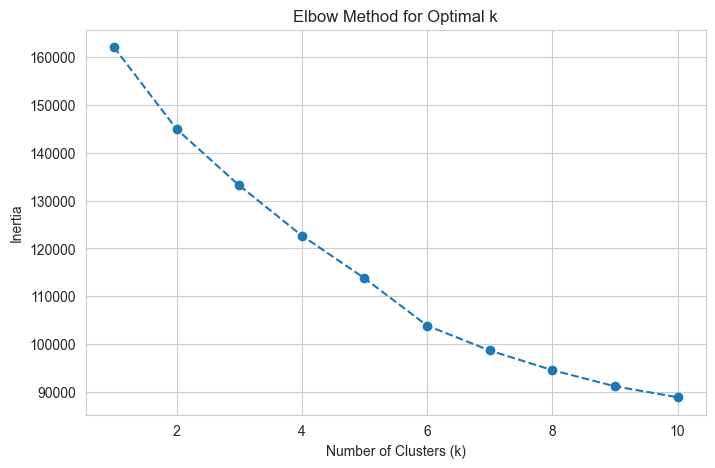

In [15]:
# Plotting the inertia vs number of clusters (k) to find the optimal k
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

It looks like 6 could be the optimal inertia, we'll go with that for now.

In [16]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
print(clusters)

[4 2 4 ... 0 3 0]


In [17]:
customers['CLUSTER'] = clusters + 1

In [18]:
customers['CLUSTER'].value_counts()

CLUSTER
1    3260
3    2884
5    1638
2     867
4     740
6     738
Name: count, dtype: int64

Now that we have the 6 different clusters, lets look at the average values of the numerical and categorical data for each one

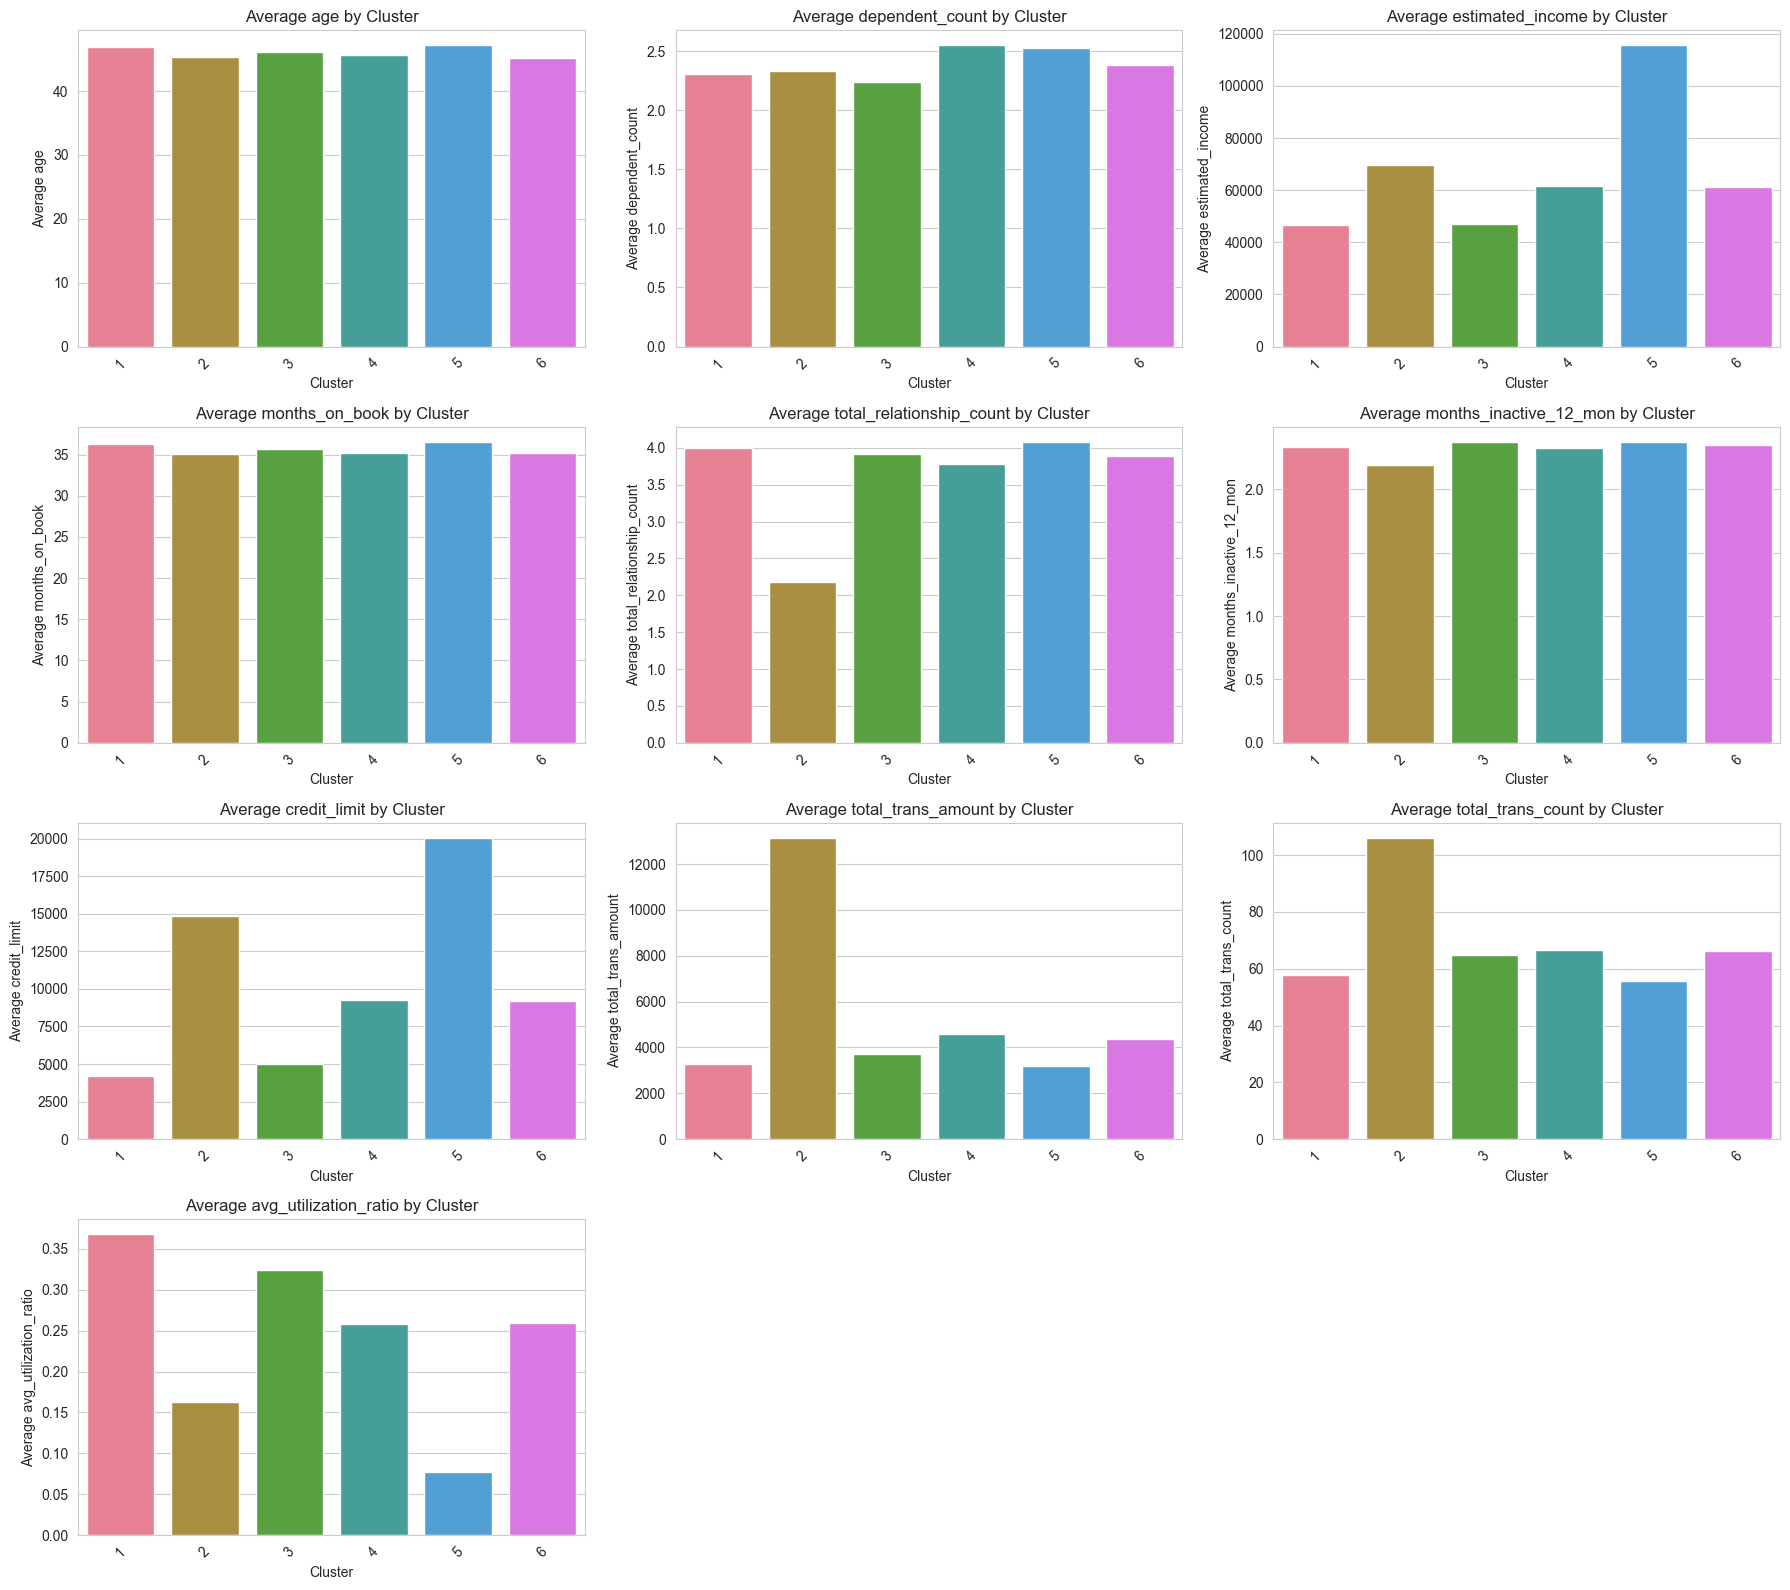

In [22]:
numerical_cols = customers.select_dtypes(include='number').columns.drop(['customer_id', 'CLUSTER'])
cluster_means = customers.groupby('CLUSTER')[numerical_cols].mean()

num_cols = 3  # Number of columns for subplots
num_rows = (len(numerical_cols) + num_cols - 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(18, num_rows * 4))  # Adjust the figure size accordingly

# Specify a color palette
palette = sns.color_palette("husl", len(cluster_means.index))

for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, num_cols, idx)
    sns.barplot(x='CLUSTER', y=col, data=cluster_means, hue='CLUSTER', palette=palette, dodge=False, legend=False)
    plt.title(f'Average {col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Average {col}')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

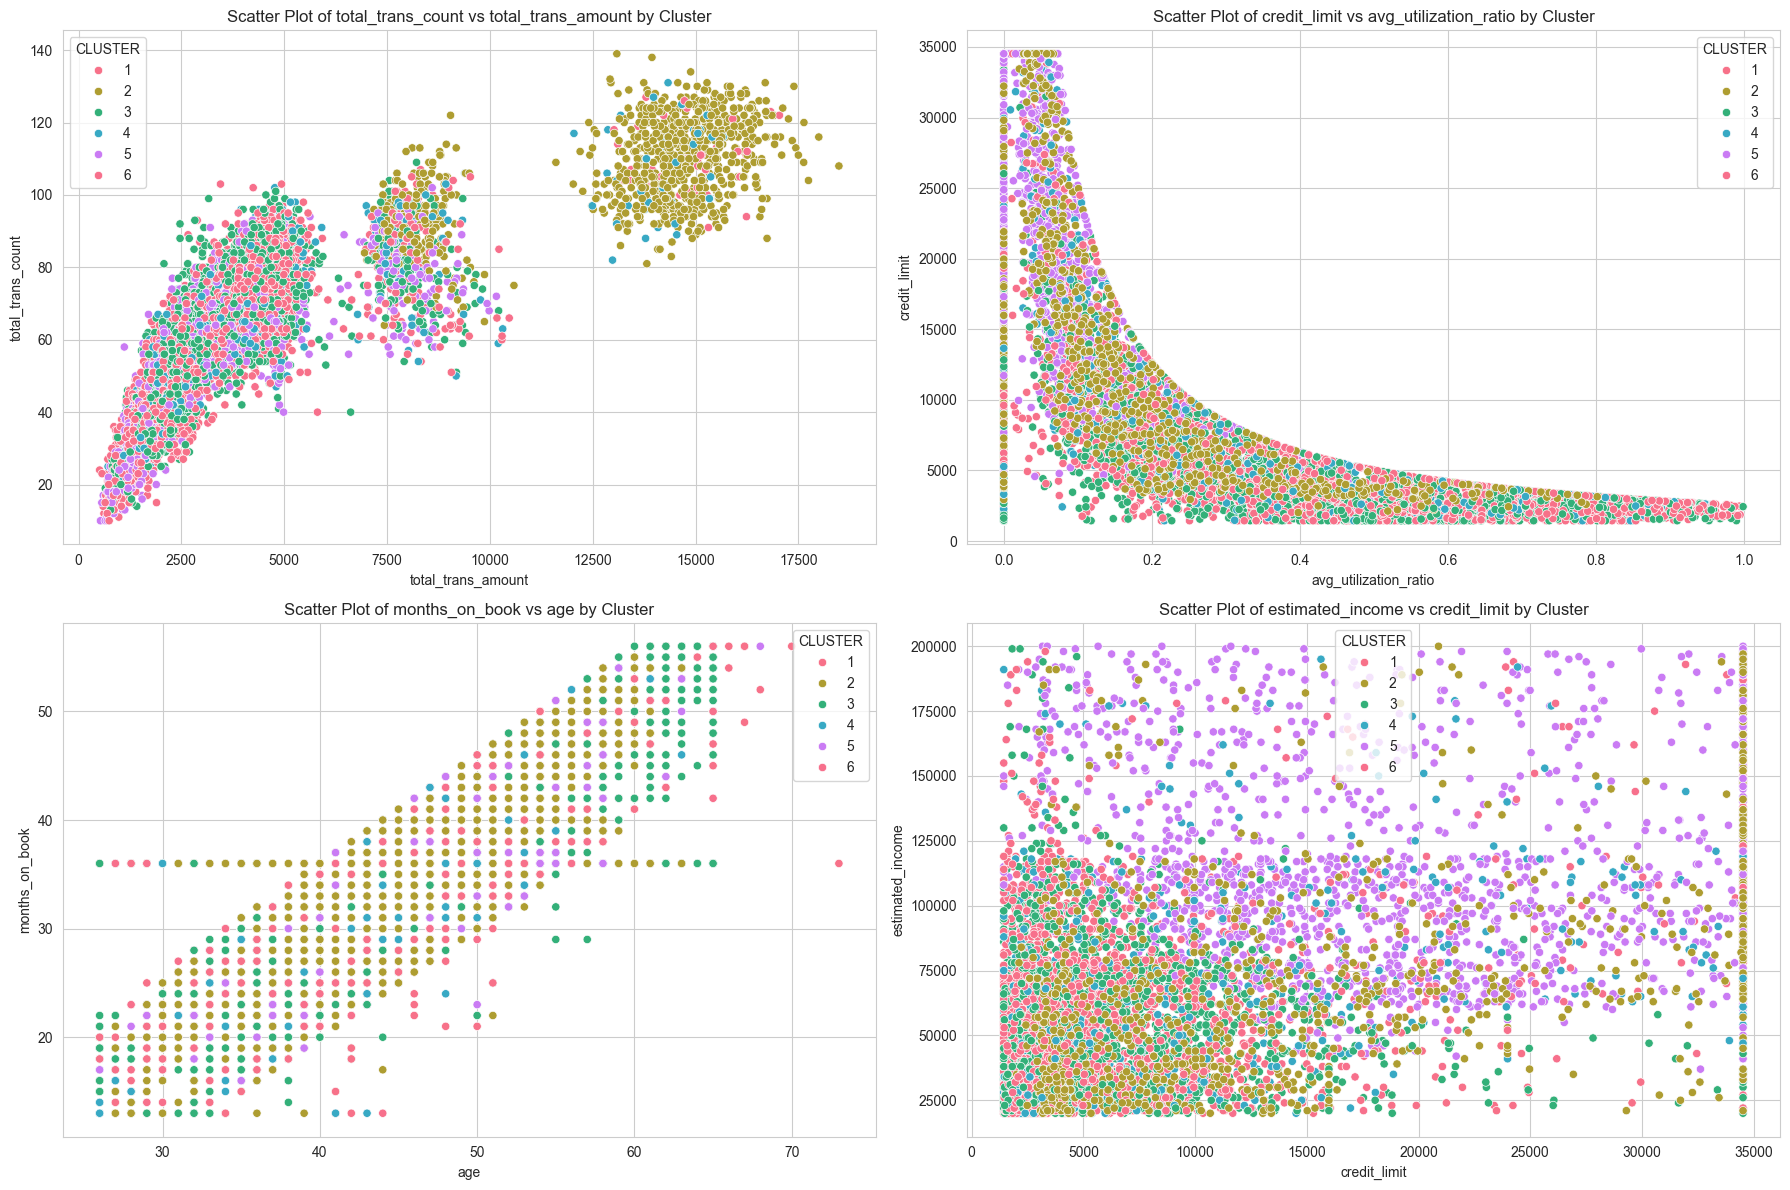

In [30]:
import seaborn as sns

# Calculate correlation for numerical columns only
numerical_cols = customers.select_dtypes(include='number').columns
correlation_matrix = customers[numerical_cols].corr()

# Define the pairs of variables with absolute correlation greater than 0.45
high_corr_pairs = [
    (col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.45
]

# Removing duplicate pairs
high_corr_pairs = list(set(tuple(sorted(pair)) for pair in high_corr_pairs))

num_cols = 2  # Number of columns for subplots
num_rows = (len(high_corr_pairs) + num_cols - 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(18, num_rows * 6))  # Adjust the figure size accordingly

for idx, (x_var, y_var) in enumerate(high_corr_pairs, 1):
    plt.subplot(num_rows, num_cols, idx)
    sns.scatterplot(x=x_var, y=y_var, hue='CLUSTER', data=customers, palette='husl', legend='full')
    plt.title(f'Scatter Plot of {y_var} vs {x_var} by Cluster')
    plt.xlabel(x_var)
    plt.ylabel(y_var)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()